<a href="https://colab.research.google.com/github/Zshoham/YHB/blob/main/assignment2/category_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py7zr

     |████████████████████████████████| 63 kB 296 kB/s eta 0:00:011
     |████████████████████████████████| 13.7 MB 702 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Data Loading

imports

In [ ]:
from tensorflow.keras.layers import Input, Embedding, dot, add, Flatten, concatenate, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model 
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import py7zr
import os

extract all data

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        with py7zr.SevenZipFile(path, mode='r') as z:
            z.extractall()

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


read all tables

In [ ]:
print('oil')
oil = pd.read_csv('./oil.csv', parse_dates=["date"])
print('items')
items = pd.read_csv('./items.csv')
print('stores')
stores = pd.read_csv('./stores.csv')
print('test')
test = pd.read_csv('./test.csv', parse_dates=["date"])
print('train')
train = pd.read_csv('./train.csv', usecols=[1, 2, 3, 4, 5], parse_dates=["date"],
                     converters={'unit_sales': lambda u: u if float(u) > 0 else 0},
                     skiprows = range(1, 118968557+1)) # read from 2017-06-15 to the end of thrain data- 2017-08-14
train.unit_sales = train.unit_sales.astype(pd.np.float64)
print('validation')
validation = pd.read_csv('./train.csv', usecols=[1, 2, 3, 4, 5], parse_dates=["date"],
                     converters={'unit_sales': lambda u: u if float(u) > 0 else 0},
                     skiprows = range(1, 115675948+1), nrows=118968556-115675948+1) # read from 2017-05-15 to 2017-06-14
validation.unit_sales = validation.unit_sales.astype(pd.np.float64)

oil
items
stores
test
train


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


validation


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


# Data preperation

In [ ]:
train.head()

And on the target variable

In [ ]:
pd.DataFrame(train['unit_sales']).describe()

Now we want to merge all relevant data to one dataset.
After looking at the different tables, we chose to merge the oil, stores and items tables with the main tables- train, test and validation. We chose to ignore from the data in the holidays_events table because even though it may help with the problem, it is too complicated to take it under concideration.
Also, we didn't took the data from transactions table because in the testing we dont have this data availble.

In order to merge the oil pricing data, we will firstly fill it with all the missing dates, and fill all missing prices with moving avarage. 

In [ ]:
dates = train.date
dates = dates.append(test.date)
dates = dates.append(validation.date)
unique_dates = pd.DataFrame({'date': dates.unique()})

oil = oil.merge(unique_dates, on='date', how='outer')
oil = oil.sort_values('date')

In [ ]:
oil = oil.fillna(oil['dcoilwtico'].rolling(10, min_periods=1, center=True, win_type='gaussian')
                 .mean(std=1).to_frame())
print(len(oil[oil['dcoilwtico'].isna()]) == 0)
print(oil.shape)
print(oil[oil['dcoilwtico'].isna()].shape)

True
(1248, 2)
(0, 2)


Let's look at the prices plot

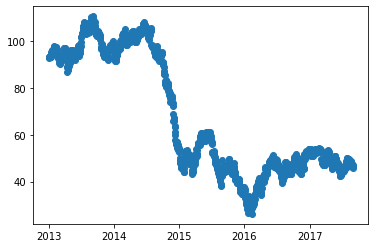

In [ ]:
plt.scatter(x=oil['date'], y=oil['dcoilwtico'])

Now we will orgenize all item numbers to be between 0 to unique items amount-1: the items_nbr are not in order so we will fix it by adding an items encoding column
We will also fix the stores number to be also between 0 to unique stores amount-1, and encode all other features

In [ ]:
le = LabelEncoder()


stores['store_enc']   = le.fit_transform(stores['store_nbr'].values)
stores['cluster_enc'] = le.fit_transform(stores['cluster'].values)
stores['state_enc']   = le.fit_transform(stores['state'].values)
stores['type_enc']    = le.fit_transform(stores['type'].values)
stores['city_enc']    = le.fit_transform(stores['city'].values)

items['item_enc']   = le.fit_transform(items['item_nbr'].values)
items['family_enc'] = le.fit_transform(items['family'].values)
items['class_enc'] = le.fit_transform(items['class'].values)

And now we can merge all tables together.

In [ ]:
def merge_data(df):
    print('1. original', df.shape)
    df = df.merge(oil, on='date', how='left')
    print('2. oil', df.shape)
    df = df.merge(stores, on='store_nbr', how='left')
    print('3. stores', df.shape)
    df = df.merge(items, on='item_nbr', how='left')
    print('4. items', df.shape)
#     df = df.merge(transactions, on=['date', 'store_nbr'], how='left')

    df['onpromotion'] = df['onpromotion'].fillna(False) # fill all unavailble data for promotion with default false
    
    df['onpromotion'] = df['onpromotion'].astype('category').cat.codes
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    df['day_enc'] = df.date.dt.dayofweek
    
    df = df.drop(['store_nbr', 'item_nbr', 'city','state', 'type', 'cluster', 'family', 'class'], axis=1)
    

    
    # check for any NaNs in data- shouldn't be any at this point
    for col in df.columns:
        nans = len(df[df[col].isna()])
        if nans > 0:
            print(col, nans)
    print('5. finally', df.shape)

    return df

print('train')
train = merge_data(train)
print('**************')
print('test')
test = merge_data(test)
print('**************')
print('validation')
validation = merge_data(validation)
print('**************')

train
1. original (6528483, 5)
2. oil (6528483, 6)
3. stores (6528483, 15)
4. items (6528483, 21)
5. finally (6528483, 14)
**************
test
1. original (3370464, 5)
2. oil (3370464, 6)
3. stores (3370464, 15)
4. items (3370464, 21)
5. finally (3370464, 14)
**************
validation
1. original (3292609, 5)
2. oil (3292609, 6)
3. stores (3292609, 15)
4. items (3292609, 21)
5. finally (3292609, 14)
**************


In [ ]:
train.head()

,date,unit_sales,onpromotion,dcoilwtico,store_enc,cluster_enc,state_enc,type_enc,city_enc,perishable,item_enc,family_enc,class_enc,day_enc
0,2017-06-15,2.0,0,44.47,0,12,12,3,18,1.00,1,12,44,3
1,2017-06-15,1.0,0,44.47,0,12,12,3,18,1.00,3,12,17,3
2,2017-06-15,1.0,0,44.47,0,12,12,3,18,1.25,4,5,187,3
3,2017-06-15,1.0,0,44.47,0,12,12,3,18,1.00,5,12,31,3
4,2017-06-15,3.0,0,44.47,0,12,12,3,18,1.00,6,12,31,3


Let's see all the uinque amount for each feature in the data.

In [ ]:
for col in train.columns:
    print(len(train[col].unique()), col)

62 date
68679 unit_sales
2 onpromotion
60 dcoilwtico
54 store_enc
17 cluster_enc
16 state_enc
5 type_enc
22 city_enc
2 perishable
3900 item_enc
33 family_enc
323 class_enc
7 day_enc


And the correlation between the features and the target variable- unit_sales

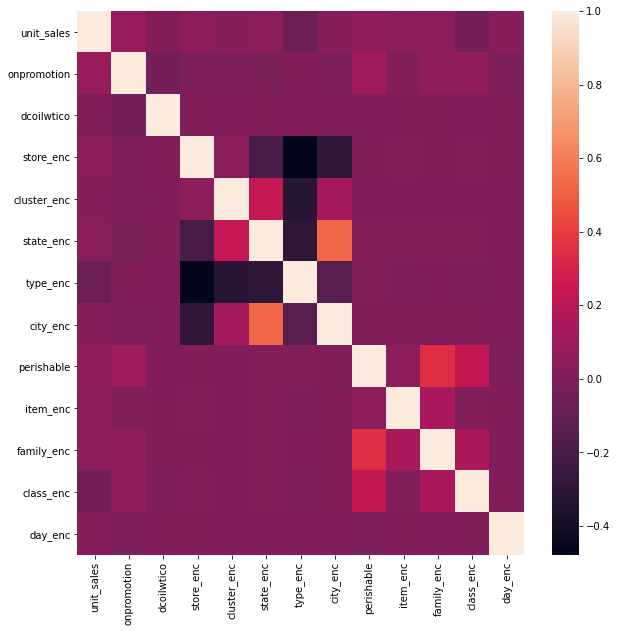

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(train.corr(), ax=ax)

As we can see in the correlation matrix, there are no two variables that have high correlation.


Now let's look on the plots of each feature vs the target variable.

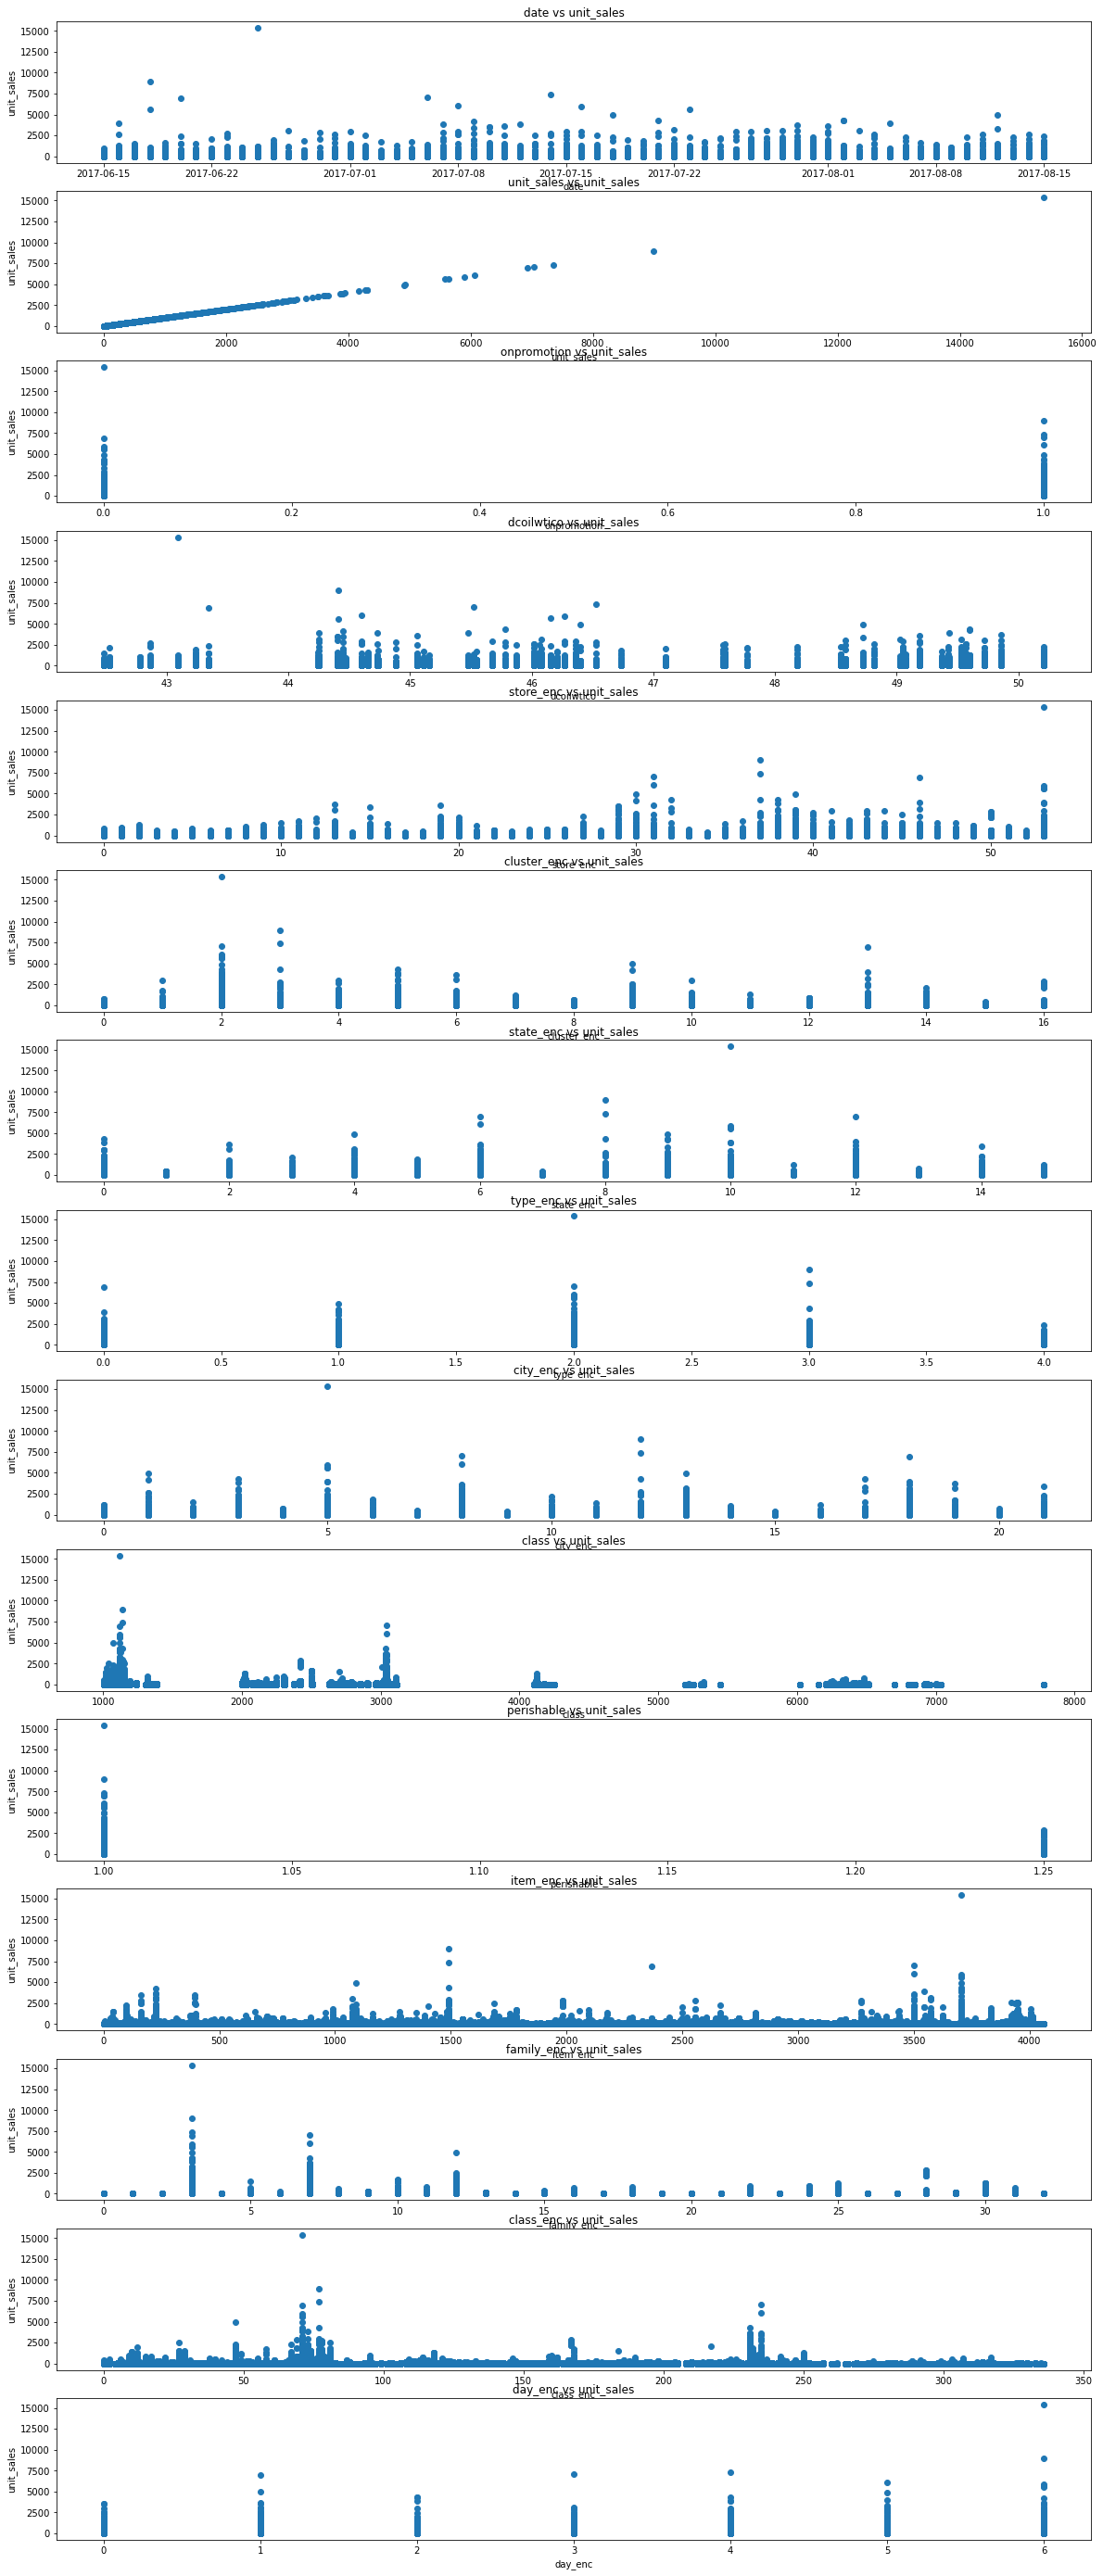

In [ ]:
features = len(train.columns)
fig, sub = plt.subplots(features, figsize=(20,50))

for i in range(features):
    col = train.columns[i]
    sub[i].scatter(x=train[col], y=train['unit_sales'])
    sub[i].set_title(str(col) + ' vs unit_sales')
    sub[i].set_xlabel(col)
    sub[i].set_ylabel('unit_sales')

We didn't find anything interesting in the data plots.

In [ ]:
def NWRMSLE(y, pred, w):
#     return mean_squared_error(y, pred, sample_weight=w)**0.5
    y = np.array(y)
    pred = np.array(pred)
    w = np.array(w)
    
    return (((w*(np.log(pred+1) - np.log(y+1)))**2).sum() / w.sum())**0.5
    

In [ ]:
def evaluate_model(model, model_name, X_val, y_val, save=False,
                   X_train=None, y_train=None, y_val_tag=None, X_test=None, y_test_tag=None):
    #fitting
    if X_train is not None and y_train is not None:
        print("fitting....")
        model.fit(X_train, y_train)
    if save:
        pickle.dump(model, open(model_name+'.h5', 'wb'))
    
    # validation
    if y_val_tag is None:
        print('predict validation....')
        y_val_tag = model.predict(X_val)
        y_val_tag = np.clip(y_val_tag, 0, max(0, y_val_tag.max()))

    val = pd.DataFrame({'id': range(len(y_val)),
                        'date': validation.date, 
                        'real': y_val, 
                        'pred': y_val_tag})
    
    print('validation NWRMSLE = %f' %(NWRMSLE(val.real, val.pred, validation.perishable)))
    
    plt.figure(figsize = (16,9))
    plt.scatter(val.real, val.pred)
    plt.title("real vs pred")
    plt.xlabel("real")
    plt.ylabel("pred")
    plt.show()

    plt.figure(figsize = (16,9))
    plt.plot('id', 'real', data=val, marker='o', markerfacecolor='blue', markersize=5, color='blue', linewidth=2)
    plt.plot('id', 'pred', data=val, marker='x', markerfacecolor='red', markersize=5, color='red', linewidth=2)
    plt.xlabel("id")
    plt.ylabel("unit_sales")
    plt.legend()
    
    # test
    if X_test is not None or y_test_tag is not None:
        print("in test")
        if y_test_tag is None:
            print("predicting test.....")
            y_test_tag = model.predict(X_test)
            y_test_tag = np.clip(y_test_tag, 0, max(0, y_test_tag.max()))
        test_predictions = pd.DataFrame({'id': test['id'], 'unit_sales': y_test_tag})
        test_predictions.to_csv('test_preds_'+model_name+'.csv', index=False)

## 3.b

those are the features we will look at in oure classical ML model

In [ ]:
features = ['onpromotion', 'dcoilwtico', 'store_enc',
            'type_enc', 'city_enc', 'state_enc', 'cluster_enc',
            'class_enc','item_enc', 'family_enc', 'day_enc']
X_train = train[features]
X_val = validation[features]
X_test = test[features]

y_train = train['unit_sales']
y_val = validation['unit_sales']

we chose to use Random forest regressor as our classical ML- we tried several other algorithms such as SVM and lightGBM. SVM tool alot of time to fit, and lgbm gave really bad results so we chose RF

In [ ]:
rfrm = RandomForestRegressor(max_depth=X_train.shape[1], n_jobs=-1, random_state=0, verbose=2)
rfrm.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.3min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


RandomForestRegressor(max_depth=11, n_jobs=-1, random_state=0, verbose=2)

predict validation....


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.7s finished


validation NWRMSLE = 0.852047


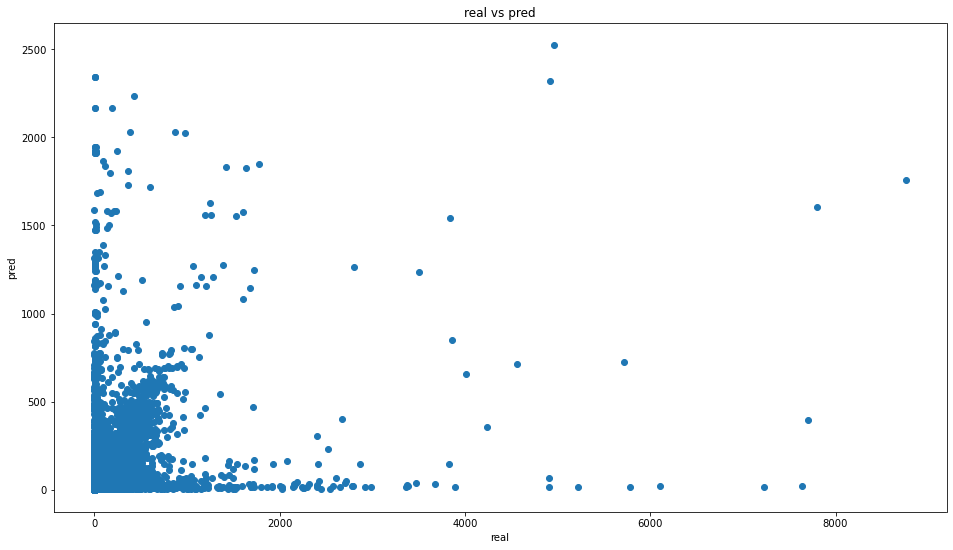

in test
predicting test.....


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished


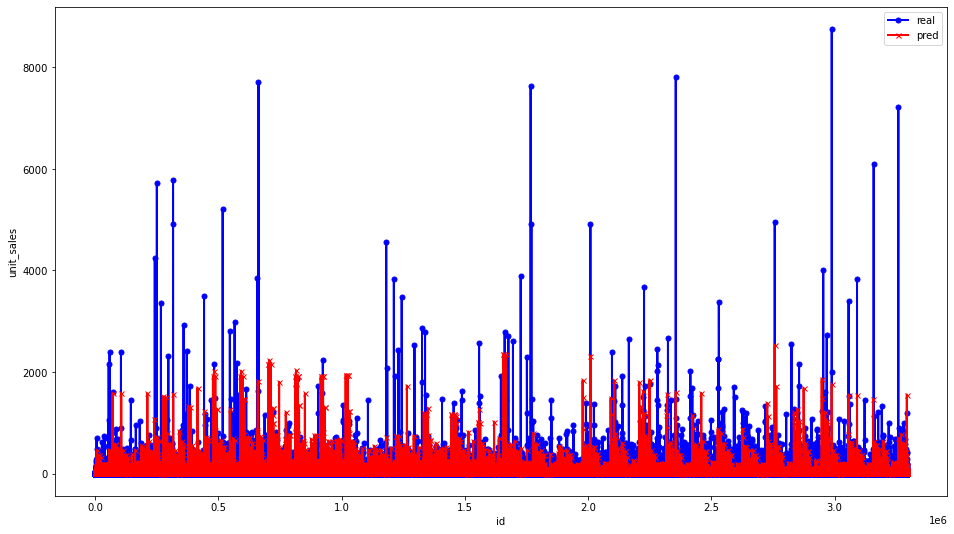

In [ ]:
evaluate_model(rfrm, 'rfrm', X_val, y_val, X_test=X_test)

![](https://i.imgur.com/YAAf8HS.png)

As we can see, RF gave avarage results

Let's try to look at the features importance to the model

Feature: onpromotion, Score: 0.01784
Feature: dcoilwtico, Score: 0.11042
Feature: store_enc, Score: 0.09885
Feature: type_enc, Score: 0.02741
Feature: city_enc, Score: 0.03514
Feature: state_enc, Score: 0.04706
Feature: cluster_enc, Score: 0.03316
Feature: class_enc, Score: 0.10456
Feature: item_enc, Score: 0.43337
Feature: family_enc, Score: 0.04848
Feature: day_enc, Score: 0.04373


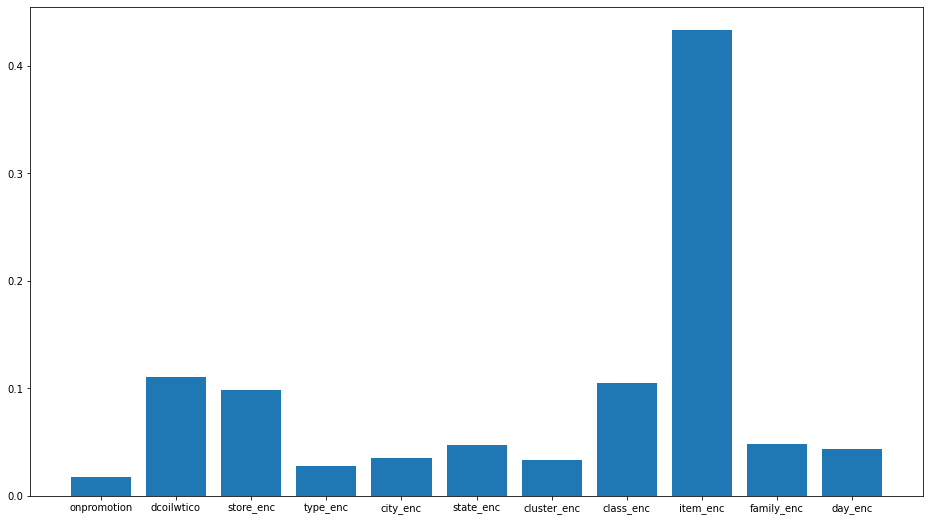

In [ ]:
importance = rfrm.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (features[i],v))
    
# plot feature importance
plt.figure(figsize = (16,9))
plt.bar([features[x] for x in range(len(importance))], importance)
plt.show()

# 3.c

Most of the relevant pre-processing done above in the data preperation section.

# 3.d

In [ ]:
def get_x_y(df, features, target=None):
    X = []
    for f in features:
        X.append(df[f])
    if target is not None:    
        y = df[target]
        return X, y
    return X

features for the embedding model- which features we will use for embeddings

In [ ]:
features = ['class_enc', 'onpromotion', 'store_enc', 'type_enc',
                'city_enc', 'state_enc', 'cluster_enc',
                'item_enc', 'family_enc', 'day_enc']
target = 'unit_sales'
X_train, y_train = get_x_y(train, features, target)
X_val, y_val = get_x_y(validation, features, target)
X_test = get_x_y(test, features)

In [ ]:
def embedding_input(name, n_in, n_out, reg=1e-4):
    inp = Input(shape=(1,), dtype='int64', name=name+'_in')
    return inp, Embedding(n_in, n_out, input_length=1, activity_regularizer=l2(reg), name=name+'_emb')(inp)

model building

In [ ]:
class_in, class_emb = embedding_input('class', len(items['class_enc'].unique()), 20)          # 20/337
promotion_in, promotion_emb = embedding_input('promotion', 2, 1)                              # 1/2
store_in, store_emb = embedding_input('store', len(stores['store_enc'].unique()), 15)         # 15/54
type_in, type_emb = embedding_input('type', len(stores['type_enc'].unique()), 3)              # 3/5
city_in, city_emb = embedding_input('city', len(stores['city_enc'].unique()), 7)              # 7/22
state_in, state_emb = embedding_input('state', len(stores['state_enc'].unique()), 5)          # 5/16
cluster_in, cluster_emb = embedding_input('cluster', len(stores['cluster_enc'].unique()), 5)  # 5/17
item_in, item_emb = embedding_input('item', len(items['item_enc'].unique()), 50)              # 50/4100
family_in, family_emb = embedding_input('family', len(items['family_enc'].unique()), 15)      # 15/33
day_in, day_emb = embedding_input('day', 7, 4)                                                # 4/7


x = concatenate([class_emb, promotion_emb, store_emb, type_emb, city_emb, state_emb,
                 cluster_emb, item_emb, family_emb, day_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)

emb_model = Model([class_in, promotion_in, store_in,
                   type_in, city_in, state_in, cluster_in,
                   item_in, family_in, day_in], x)
emb_model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
emb_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
promotion_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
type_in (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

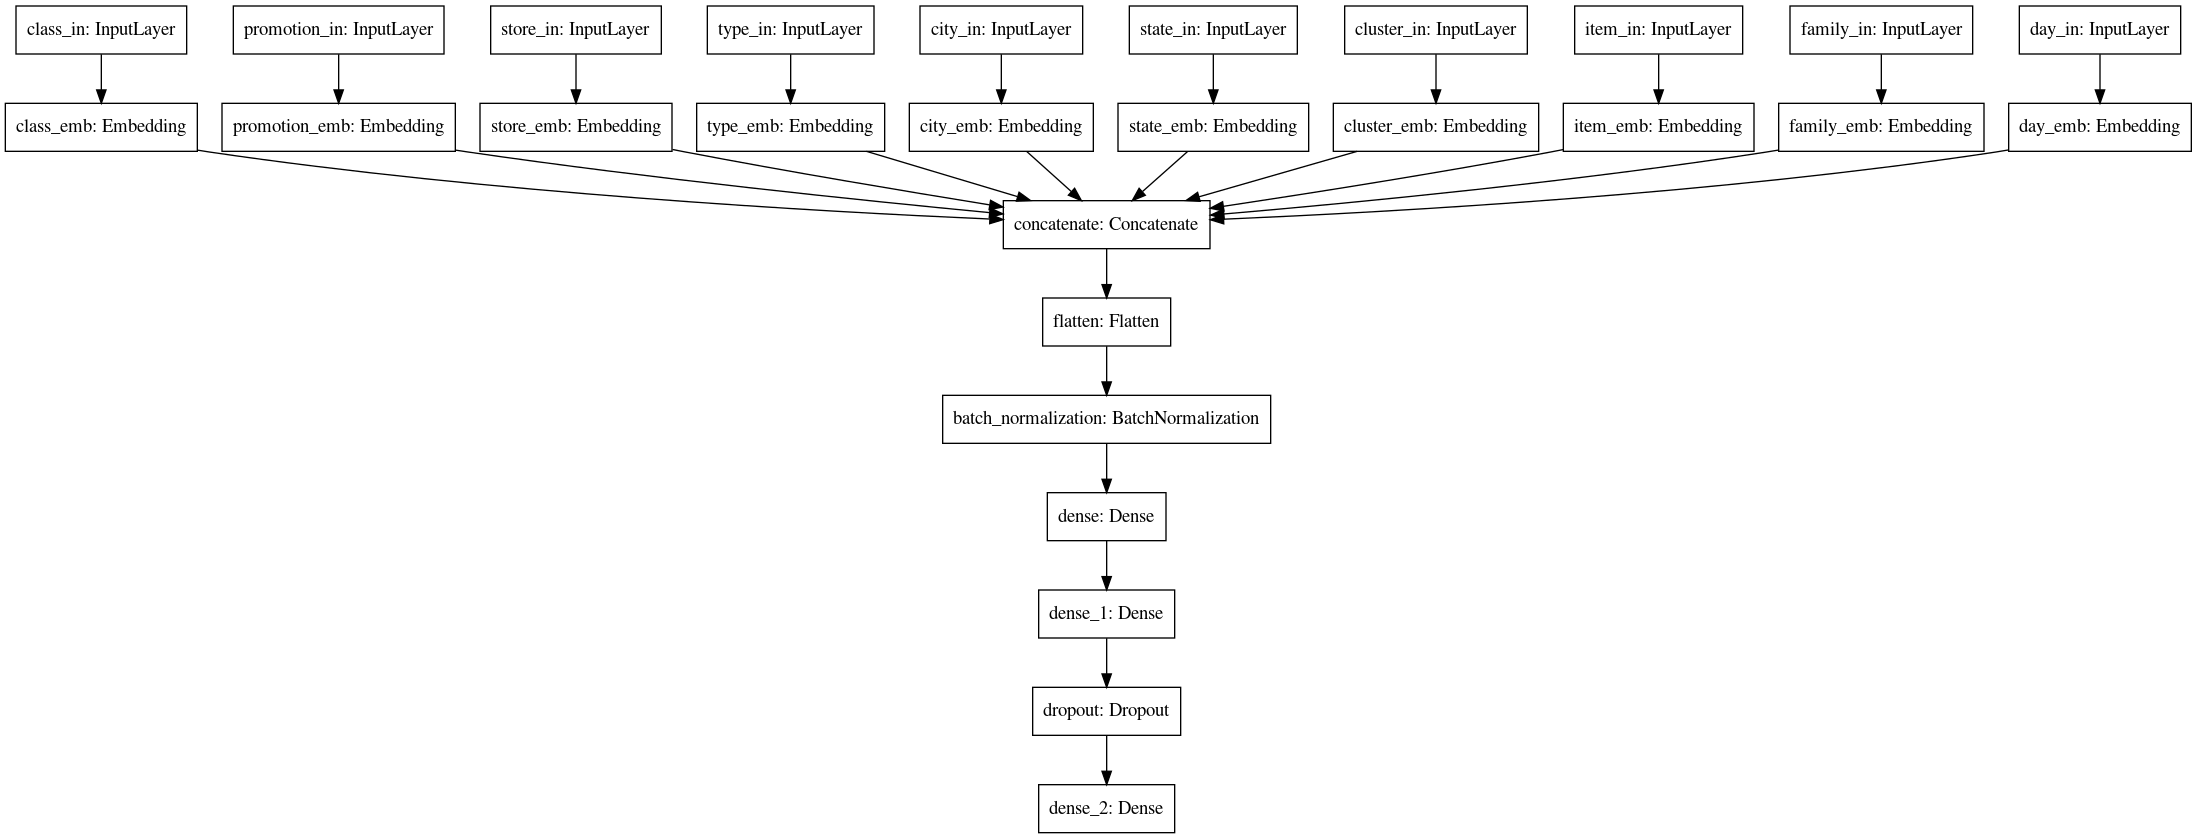

In [ ]:
plot_model(emb_model)

In [ ]:
emb_model.fit(X_train,y_train, batch_size=2**10, epochs=5, verbose=1,
              validation_data=(X_val, y_val))

Epoch 1/5
6376/6376 [==============================] - 74s 12ms/step - loss: 416.5959 - mae: 4.9596 - val_loss: 483.2010 - val_mae: 5.0121
Epoch 2/5
6376/6376 [==============================] - 74s 12ms/step - loss: 371.3690 - mae: 4.8577 - val_loss: 476.7469 - val_mae: 4.9871
Epoch 3/5
6376/6376 [==============================] - 73s 11ms/step - loss: 348.5301 - mae: 4.8031 - val_loss: 477.5634 - val_mae: 4.9574
Epoch 4/5
6376/6376 [==============================] - 78s 12ms/step - loss: 340.0145 - mae: 4.7901 - val_loss: 468.6597 - val_mae: 4.8741
Epoch 5/5
6376/6376 [==============================] - 72s 11ms/step - loss: 338.0069 - mae: 4.7846 - val_loss: 457.1163 - val_mae: 4.8121


In [ ]:
def predict(model, x):
    y = model.predict(x, batch_size=128, verbose=1, workers=4, use_multiprocessing=True)
    y = y.reshape(-1)
    y = np.clip(y, 0, max(0, y.max()))
    return y

In [ ]:
y_val_tag = predict(emb_model, X_val)

25724/25724 [==============================] - 31s 1ms/step


In [ ]:
y_test_tag = predict(emb_model, X_test)

26332/26332 [==============================] - 31s 1ms/step


validation NWRMSLE = 0.693100


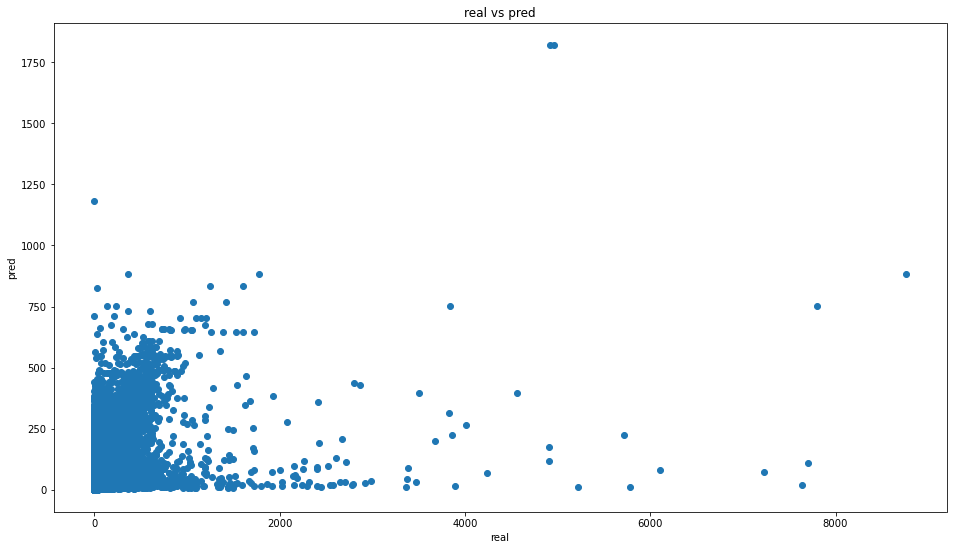

in test


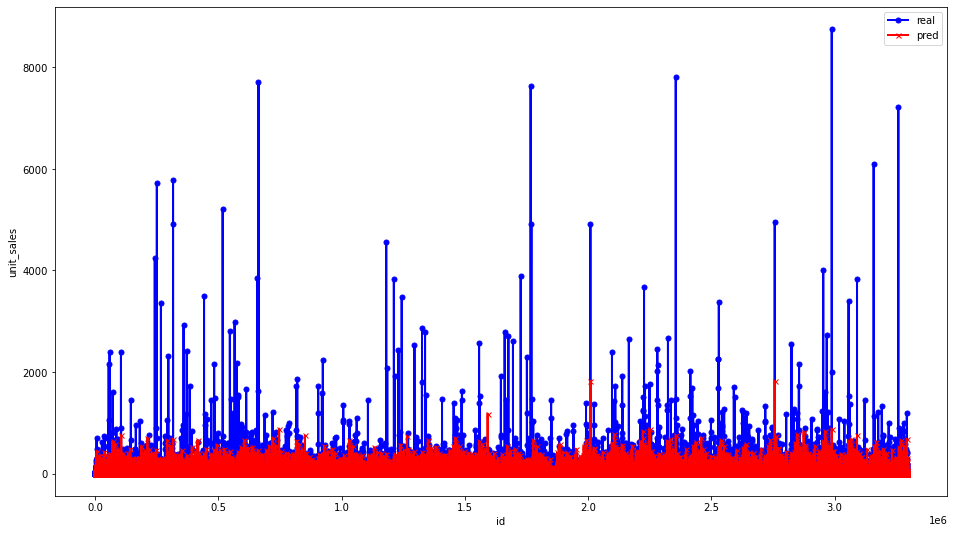

In [ ]:
evaluate_model(emb_model, 'embedding', X_val, y_val,
               y_val_tag=y_val_tag, y_test_tag=y_test_tag)

![](https://i.imgur.com/U8Xljfu.png)

as we can see the embedding model gave us slightly better results, but still only avarage

# 3.e

features for our bigger network- we will try to add the oil prices as feature to the embedding network from 3.d

In [ ]:
features = ['dcoilwtico', 'class_enc', 'onpromotion', 'store_enc',
            'type_enc', 'city_enc', 'state_enc', 'cluster_enc',
            'item_enc', 'family_enc', 'day_enc']
target = 'unit_sales'
X_train, y_train = get_x_y(train, features, target)
X_val, y_val = get_x_y(validation, features, target)
X_test = get_x_y(test, features)

In [ ]:
oil_in = Input(shape=(1,1), dtype='float64', name='oil_in')

class_in, class_emb = embedding_input('class', len(items['class_enc'].unique()), 20)          # 20/337
promotion_in, promotion_emb = embedding_input('promotion', 2, 1)                              # 1/2
store_in, store_emb = embedding_input('store', len(stores['store_enc'].unique()), 15)         # 15/54
type_in, type_emb = embedding_input('type', len(stores['type_enc'].unique()), 3)              # 3/5
city_in, city_emb = embedding_input('city', len(stores['city_enc'].unique()), 7)              # 7/22
state_in, state_emb = embedding_input('state', len(stores['state_enc'].unique()), 5)          # 5/16
cluster_in, cluster_emb = embedding_input('cluster', len(stores['cluster_enc'].unique()), 5)  # 5/17
item_in, item_emb = embedding_input('item', len(items['item_enc'].unique()), 50)              # 50/4100
family_in, family_emb = embedding_input('family', len(items['family_enc'].unique()), 15)      # 15/33
day_in, day_emb = embedding_input('day', 7, 4)                                                # 4/7


x = concatenate([oil_in, class_emb, promotion_emb, store_emb, type_emb, city_emb, state_emb,
                 cluster_emb, item_emb, family_emb, day_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)

model = Model([oil_in, class_in, promotion_in, store_in,
                   type_in, city_in, state_in, cluster_in,
                   item_in, family_in, day_in], x)
model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
promotion_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
type_in (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

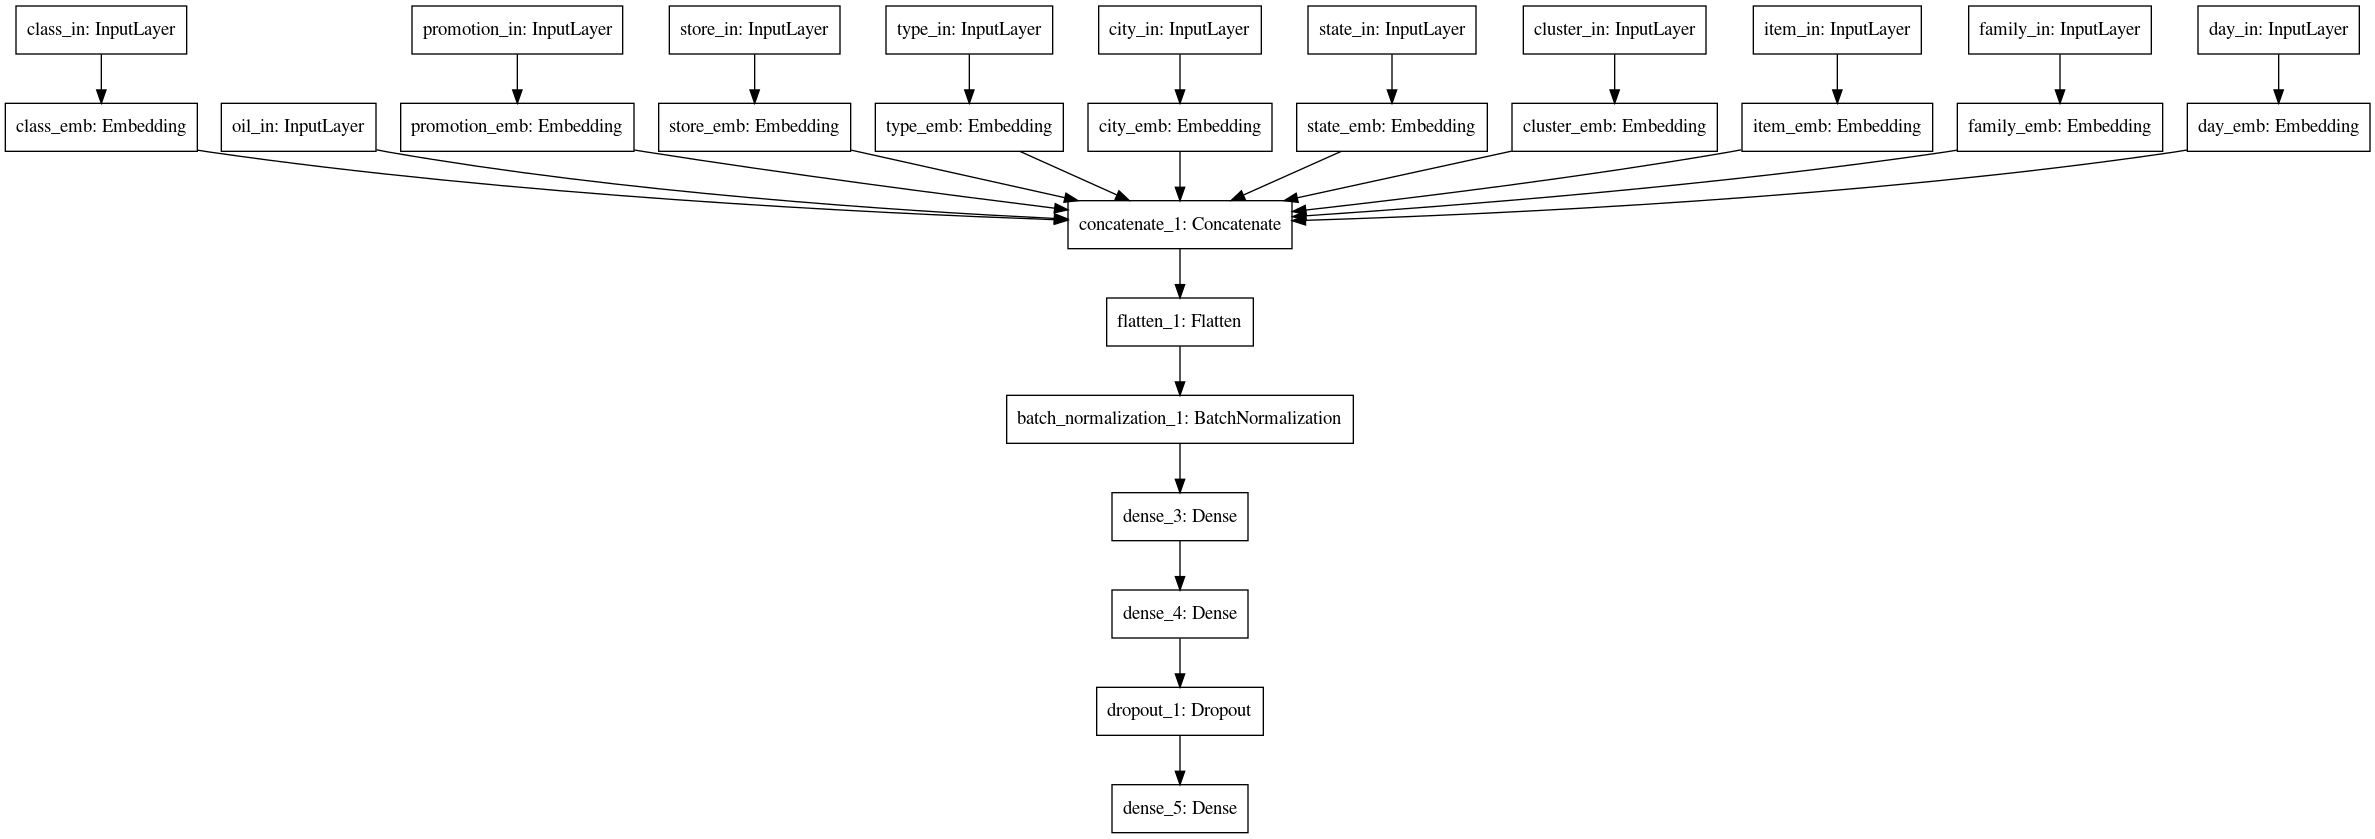

In [ ]:
plot_model(model)

In [ ]:
model.fit(X_train,y_train, batch_size=2**10, epochs=5, verbose=1,
              validation_data=(X_val, y_val))

Epoch 1/5
6376/6376 [==============================] - 55s 9ms/step - loss: 422.5952 - mae: 4.9965 - val_loss: 498.8404 - val_mae: 5.1155
Epoch 2/5
6376/6376 [==============================] - 54s 8ms/step - loss: 371.9815 - mae: 4.8001 - val_loss: 488.2297 - val_mae: 4.9868
Epoch 3/5
6376/6376 [==============================] - 54s 8ms/step - loss: 360.5562 - mae: 4.8526 - val_loss: 481.2463 - val_mae: 4.9285
Epoch 4/5
6376/6376 [==============================] - 54s 9ms/step - loss: 349.6066 - mae: 4.8805 - val_loss: 480.0167 - val_mae: 4.9209
Epoch 5/5
6376/6376 [==============================] - 55s 9ms/step - loss: 345.4088 - mae: 4.8650 - val_loss: 502.9694 - val_mae: 5.0753


In [ ]:
y_val_tag = predict(model, X_val)

25724/25724 [==============================] - 30s 1ms/step


In [ ]:
y_test_tag = predict(model, X_test)

26332/26332 [==============================] - 32s 1ms/step


validation NWRMSLE = 0.704700


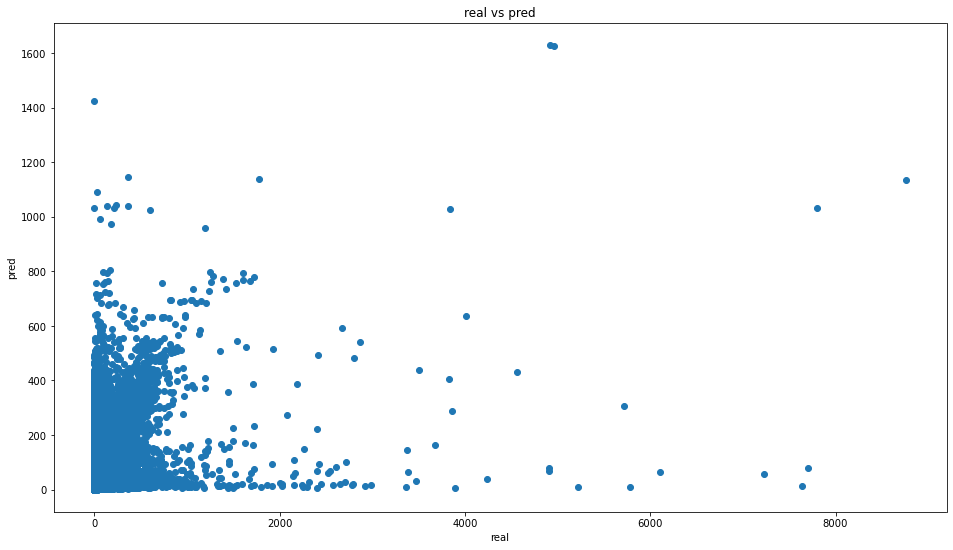

in test


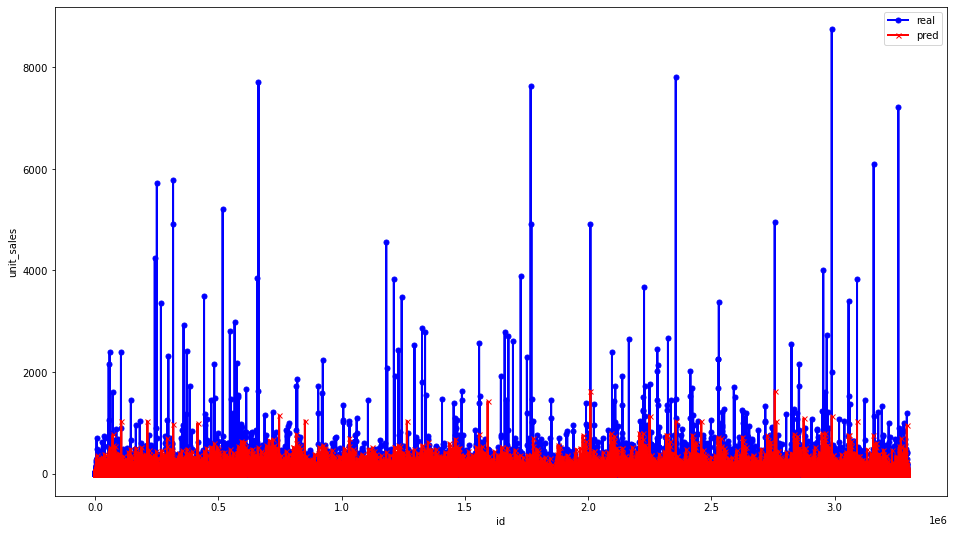

In [ ]:
evaluate_model(model, '3e', X_val, y_val,
               y_val_tag=y_val_tag, y_test_tag=y_test_tag)

![](https://i.imgur.com/bdVIz3e.png)

as we can see the oil prices addition improved our model slightly, but not so much

# 3.f

we will look at the embedding of the store numbers, compared to the original store clustering recived in store dataset

In [ ]:
emb_store_model = Model(inputs=emb_model.get_layer('store_in').input,
                        outputs=emb_model.get_layer('store_emb').output)

In [ ]:
clusters_colors = {0 : '#FF0000',
                   1 : '#FF00DE',
                   2 : '#9A00FF',
                   3 : '#2B00FF',
                   4 : '#00A2FF',
                   5 : '#00FF3C',
                   6 : '#E6FF00',
                   7 : '#FFCD00',
                   8 : '#981919',
                   9 : '#199865',
                   10: '#984719',
                   11: '#EB5A5A', 
                   12: '#815AEB',
                   13: '#5AEB81',
                   14: '#6D6F6E',
                   15: '#97B77B',
                   16: '#33610C'}

In [ ]:
pca = PCA(n_components=2)
s = emb_store_model.predict(stores.store_enc.unique())
pca.fit(np.squeeze(s))

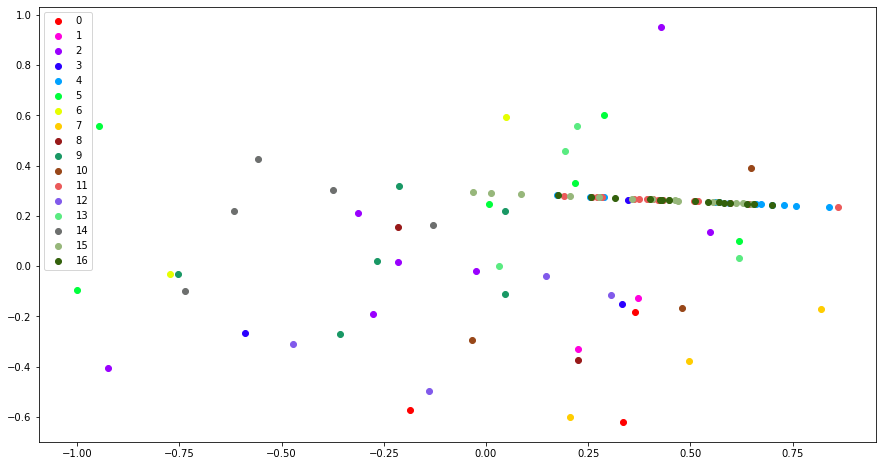

In [ ]:
plt.figure(figsize=(15,8))

for cluster in range(len(stores.cluster_enc.unique())):
#     print(cluster)
    strs = stores[stores['cluster_enc']==cluster].store_enc
    store_embeddings = emb_store_model.predict(strs)
    
    store_embeddings = np.squeeze(store_embeddings)
    if len(store_embeddings.shape) < 2:
        store_embeddings=store_embeddings.reshape(-1,1)
    store_embeddings = pca.transform(store_embeddings)

    x_plt = store_embeddings[:,0]
    y_plt = store_embeddings[:,1]
    
    plt.scatter(x_plt,y_plt, c=clusters_colors[cluster], label=cluster)
plt.legend(loc='upper left')
plt.show()

As we can see in the figure above, all the stores in clusters 16, 4, 15 aligned in one line- which might suggest the model was able to learn good embedding to part of the stores, but not to others (like cluster 2 which is very scatterd).

# 3.g

the features we will use for feature extraction 

In [ ]:
features = ['class_enc', 'onpromotion', 'store_enc', 'type_enc',
                'city_enc', 'state_enc', 'cluster_enc',
                'item_enc', 'family_enc', 'day_enc']
target = 'unit_sales'
X_train, y_train = get_x_y(train, features, target)
X_val, y_val = get_x_y(validation, features, target)
X_test = get_x_y(test, features)

We will ture the embedding model from 3.d right after the flatten layer to recive all of the new features produced by the embeddings.

In [ ]:
fe_model = Model(emb_model.input, emb_model.layers[-6].output)
fe_model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
fe_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
promotion_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
type_in (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

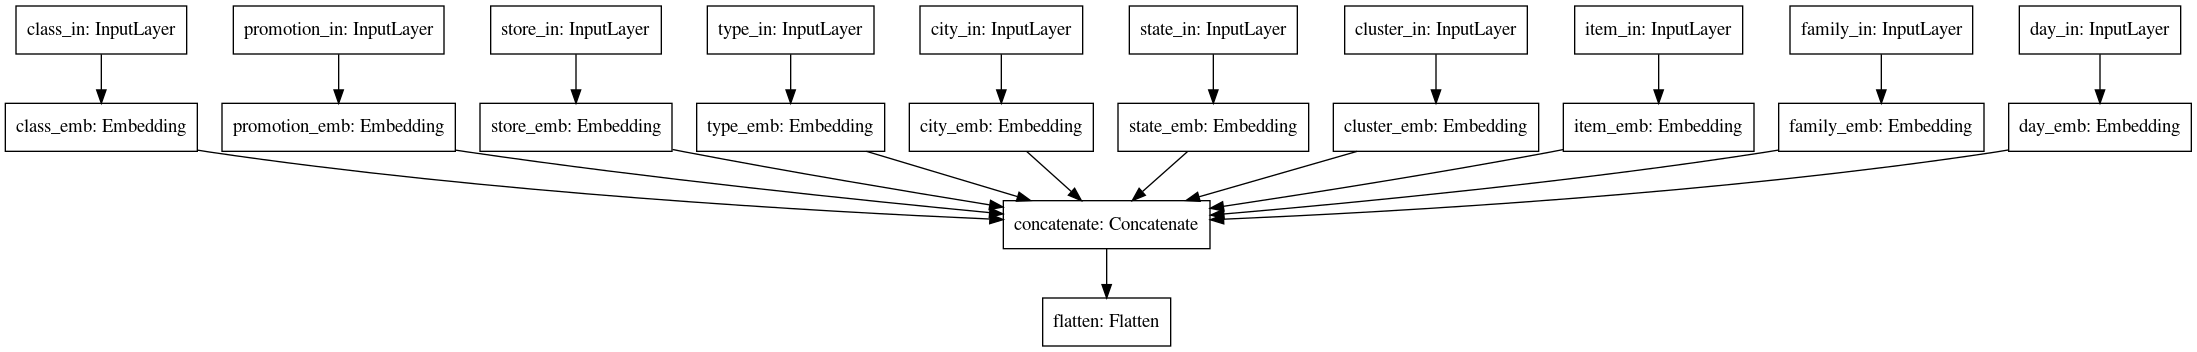

In [ ]:
plot_model(fe_model)

And now to create the new dataset- we will feed the network with all our data to recive the new features

In [ ]:
fe_x_train = fe_model.predict(X_train, batch_size=128, verbose=1, workers=4, use_multiprocessing=True)

51004/51004 [==============================] - 54s 1ms/step


In [ ]:
import gc

del train
del X_train
gc.collect()

10426

In [ ]:
fe_x_val = fe_model.predict(X_val, batch_size=128, verbose=1, workers=4, use_multiprocessing=True)

25724/25724 [==============================] - 26s 1ms/step


In [ ]:
fe_x_test = fe_model.predict(X_test, batch_size=128, verbose=1, workers=4, use_multiprocessing=True)

26332/26332 [==============================] - 27s 1ms/step


After some tries on different algorithms like SVM and RF which took too much time to run, and SGD which took too much memory which we didnt have at this point, we used the LGB  model.

In [ ]:
import lightgbm as lgb

# create dataset for lightgbm
lgb_train = lgb.Dataset(fe_x_train, y_train)
lgb_eval = lgb.Dataset(fe_x_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=30,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Starting training...
[1]	valid_0's l1: 7.49024	valid_0's l2: 662.778
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 7.39515	valid_0's l2: 654.037
[3]	valid_0's l1: 7.2967	valid_0's l2: 645.752
[4]	valid_0's l1: 7.21041	valid_0's l2: 637.77
[5]	valid_0's l1: 7.12011	valid_0's l2: 630.049
[6]	valid_0's l1: 7.03072	valid_0's l2: 621.941
[7]	valid_0's l1: 6.9545	valid_0's l2: 615.039
[8]	valid_0's l1: 6.8854	valid_0's l2: 609.58
[9]	valid_0's l1: 6.82235	valid_0's l2: 604.529
[10]	valid_0's l1: 6.75764	valid_0's l2: 598.056
[11]	valid_0's l1: 6.69727	valid_0's l2: 592.114
[12]	valid_0's l1: 6.63534	valid_0's l2: 587.435
[13]	valid_0's l1: 6.57961	valid_0's l2: 582.804
[14]	valid_0's l1: 6.52647	valid_0's l2: 578.823
[15]	valid_0's l1: 6.48377	valid_0's l2: 573.563
[16]	valid_0's l1: 6.44147	valid_0's l2: 568.622
[17]	valid_0's l1: 6.39008	valid_0's l2: 565.091
[18]	valid_0's l1: 6.34984	valid_0's l2: 560.436
[19]	valid_0's l1: 6.31353	valid_0's l2: 557.348
[2

In [ ]:
y_tag_val = gbm.predict(fe_x_val, num_iteration=gbm.best_iteration)
y_tag_val = np.clip(y_tag_val, 0, max(0, y_tag_val.max()))

y_tag_test = gbm.predict(fe_x_test, num_iteration=gbm.best_iteration)
y_tag_test = np.clip(y_tag_test, 0, max(0, y_tag_test.max()))

validation NWRMSLE = 0.844592


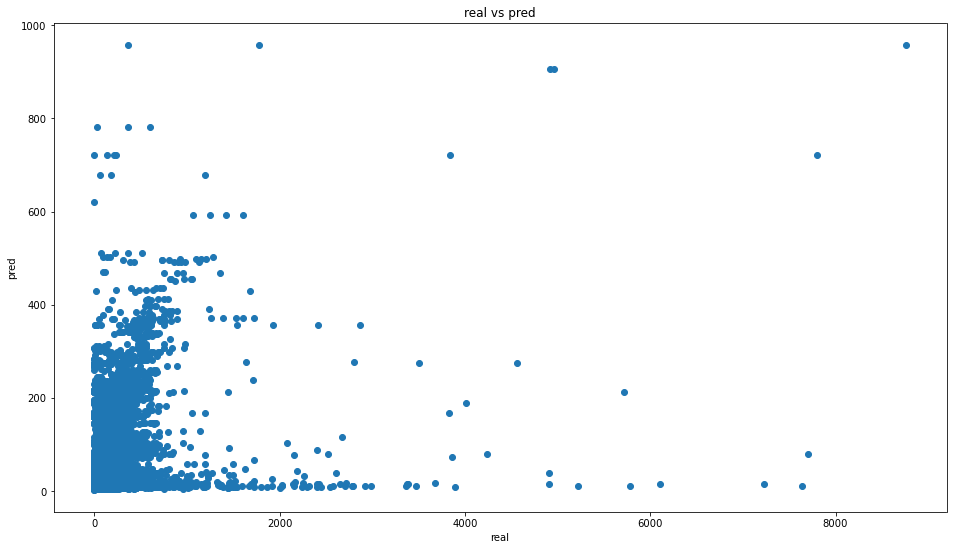

in test


NameError: name 'test' is not defined

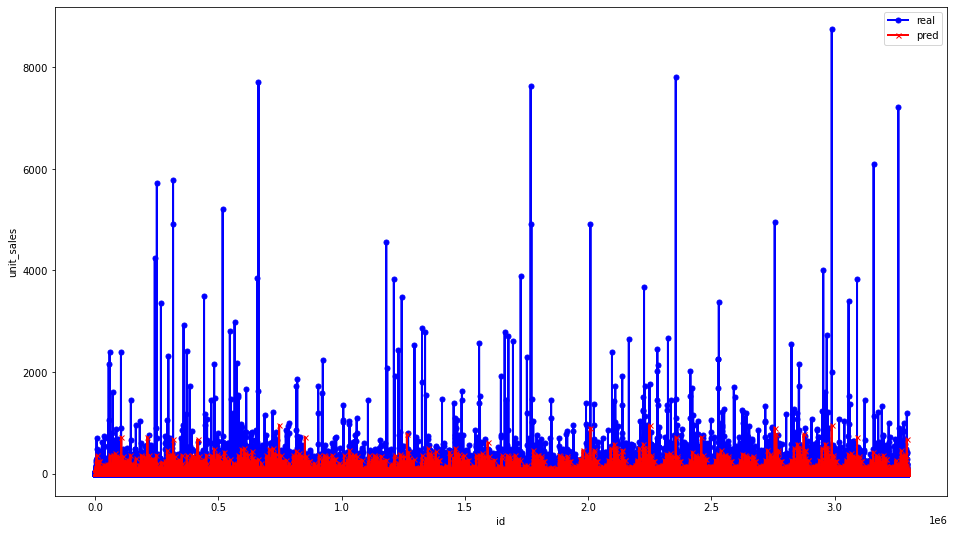

In [ ]:
evaluate_model(gbm, 'fe_gbm', fe_x_val, y_val,
                   y_val_tag=y_tag_val, y_test_tag=y_tag_test)

![](https://i.imgur.com/lHAa2qi_d.webp?maxwidth=760&fidelity=grand)

As we can see this model gave us the worst results so far.